# Generate h5ad input file

In [1]:
# Loading the Packages

%load_ext autoreload
%autoreload 2

import os
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

# from starmap.obj import STARMapDataset, load_data
# import starmap.analyze as anz
# import starmap.viz as viz
import starmap.sc_util as su
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# test
from starmap.utilities import *
from starmap.sequencing import *
from anndata import AnnData

# test()

## IO

In [25]:
# Set path
base_path = 'Z:/Data/Analyzed/2022-01-03-Hu-AD/'
out_path = os.path.join(base_path, 'output')
fig_path = os.path.join(base_path, 'figures')

out_path = os.path.join(base_path, 'output')
if not os.path.exists(out_path):
    os.mkdir(out_path)
    
fig_path = os.path.join(base_path, 'figures')
if not os.path.exists(fig_path):
    os.mkdir(fig_path)
    
sample_list = ['8months_disease', '8months_control', '13months_disease', '13months_control']
id_list = ['ADmouse_9723', 'ADmouse_9707', 'ADmouse_11346', 'ADmouse_11351']
batch_list = ['batch_3', 'batch_4', 'batch_4', 'batch_4']

## Input

In [26]:
# adata = sc.read_h5ad('J:/2020-10-09-mAD-2766-genes-reads-assignment/output/2021-06-04-starmap-mAD-raw.h5ad')
# adata.obs

In [27]:
# Combine adata of each sample
adata = None

for i, sample in enumerate(sample_list):
    current_adata_path = os.path.join(base_path, sample, 'results', f'2022-02-13-Hu-AD-{sample}-raw.h5ad')
    current_adata = sc.read_h5ad(current_adata_path)
    current_adata.obs.columns = ['x', 'y', 'z']
    current_adata.obs['orig_index'] = current_adata.obs.index.values
    current_adata.obs['orig_index'] = current_adata.obs['orig_index'].astype(int)
    current_adata.obs['sample'] = id_list[i]
    current_adata.obs['time'] = sample_list[i].split('_')[0]
    current_adata.obs['group'] = sample_list[i].split('_')[1]
    current_adata.obs['batch'] = batch_list[i]
    
    if not adata:
        adata = current_adata
    else:
        adata = adata.concatenate(current_adata, batch_key='concat')
        
adata.obs = adata.obs.drop(columns=['concat'])
adata.obs = adata.obs.reset_index(drop=True)
adata.obs.index = adata.obs.index.astype(str)

In [28]:
# change obs columns to categorical variable 
adata.obs['sample'] = adata.obs['sample'].astype('category')
adata.obs['sample'] = adata.obs['sample'].cat.reorder_categories(id_list)

adata.obs['batch'] = adata.obs['batch'].astype('category')
adata.obs['batch'] = adata.obs['batch'].cat.reorder_categories(['batch_3', 'batch_4'])

adata.obs['time'] = adata.obs['time'].astype('category')
adata.obs['time'] = adata.obs['time'].cat.reorder_categories(['8months', '13months'])

adata.obs['group'] = adata.obs['group'].astype('category')

In [29]:
# # save combined h5ad
# from datetime import datetime
# date = datetime.today().strftime('%Y-%m-%d')
# adata.write_h5ad(f"{out_path}/{date}-Hu-AD-combined-raw.h5ad")

## Quality assessment

### Statistics

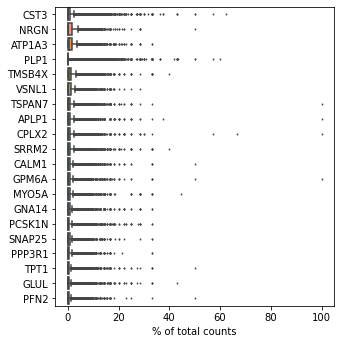

In [30]:
# Plot top 20 most expressed genes (before qc)
sc.pl.highest_expr_genes(adata, n_top=20)

In [31]:
# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, percent_top=None, inplace=True)

# Calculate max count for each gene
adata.var['max_counts'] = adata.X.max(axis=0)

In [32]:
# Total counts describe statistics
adata.obs['total_counts'].describe()

count    57376.000000
mean       151.193771
std        126.982689
min          1.000000
25%         51.000000
50%        121.000000
75%        220.000000
max       1021.000000
Name: total_counts, dtype: float64

In [33]:
adata.obs['log1p_total_counts'].describe()

count    57376.000000
mean         4.581998
std          1.074921
min          0.693147
25%          3.951244
50%          4.804021
75%          5.398163
max          6.929517
Name: log1p_total_counts, dtype: float64

In [42]:
from scipy import stats
n = 1.5
mad = stats.median_absolute_deviation(adata.obs['log1p_total_counts'], scale=1)
lower_bd = adata.obs['log1p_total_counts'].median() - n*mad
upper_bd = adata.obs['log1p_total_counts'].median() + n*mad

print(lower_bd)
print(upper_bd)
print(np.expm1(lower_bd))
print(np.expm1(upper_bd))

3.7766454219818115
5.8313963413238525
42.66930366488294
339.83426792517906


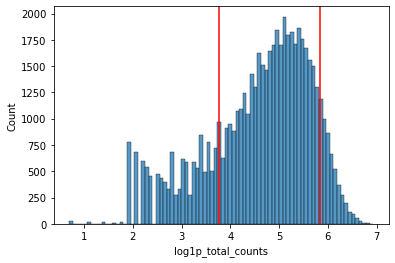

In [43]:
sns.histplot(adata.obs['log1p_total_counts'])
plt.axvline(lower_bd, c='r')
plt.axvline(upper_bd, c='r')
plt.show()

In [44]:
# Total counts describe statistics
adata.var['total_counts'].describe()

count      2766.000000
mean       3136.259521
std        6508.354492
min          84.000000
25%         641.000000
50%        1258.500000
75%        2816.500000
max      103376.000000
Name: total_counts, dtype: float64

In [45]:
# max counts describe statistics
adata.var['max_counts'].describe()

count    2766.000000
mean        3.973247
std         3.648281
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        96.000000
Name: max_counts, dtype: float64

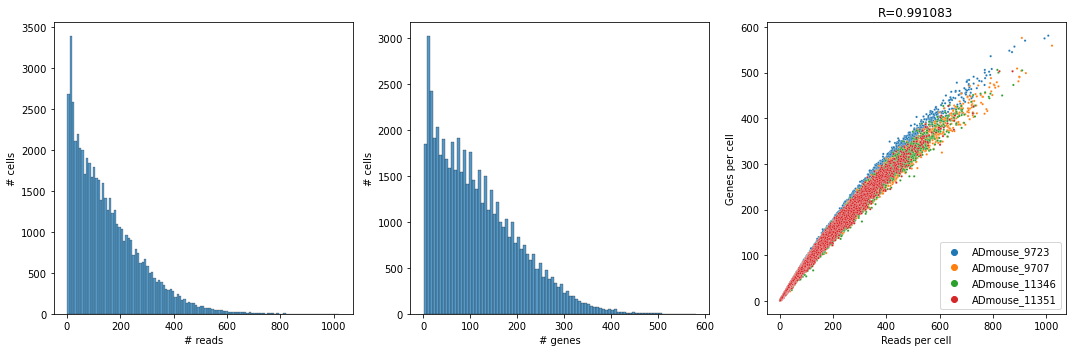

In [46]:
# Per-cell Stats Plot

su.plot_stats_per_cell(adata, color='sample', save=False)

In [47]:
# Get quantiles of reads
su.show_reads_quantile(adata)

Reads per cell quantile:
0.10     17.0
0.25     51.0
0.50    121.0
0.75    220.0
0.90    327.0
Name: total_counts, dtype: float64


### Filtration

In [48]:
# Filtration 
sc.pp.filter_cells(adata, min_genes=10)
sc.pp.filter_genes(adata, min_cells=10)

# Filter gene by max counts 
adata = adata[:, adata.var['max_counts'] > 2]

sc.pp.filter_cells(adata, min_counts=np.expm1(lower_bd))
sc.pp.filter_cells(adata, max_counts=np.expm1(upper_bd))

adata.layers['raw'] = adata.X
adata.X.shape

Trying to set attribute `.obs` of view, copying.


(40069, 2005)

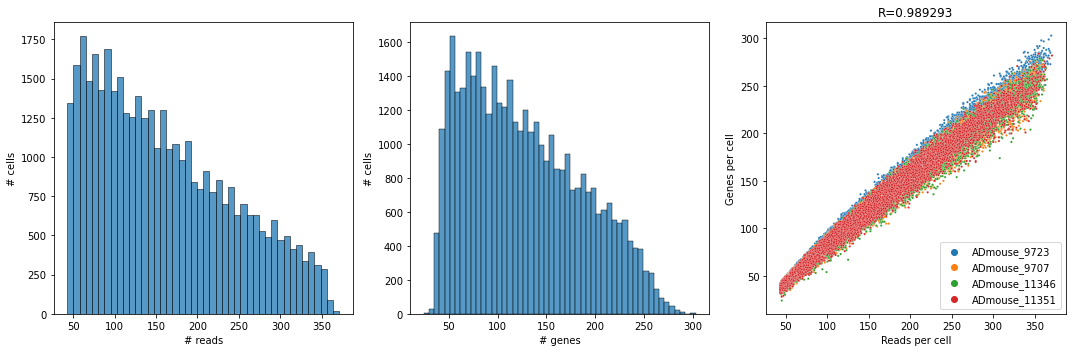

In [49]:
# Per-cell Stats Plot

su.plot_stats_per_cell(adata, color='sample', save=False)

In [50]:
# Get quantiles of reads
su.show_reads_quantile(adata)

Reads per cell quantile:
0.10     62.0
0.25     91.0
0.50    145.0
0.75    220.0
0.90    286.0
Name: total_counts, dtype: float64


### Output

In [51]:
# save combined h5ad
from datetime import datetime
date = datetime.today().strftime('%Y-%m-%d')
adata.write_h5ad(f"{out_path}/{date}-Hu-AD-combined-filtered-1_5mad.h5ad")